In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install pymorphy2
import re
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

np.random.seed(42)
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 93.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=955561473eeda20aa668f979a4e4ca0ca3d6d46453b184997cabc39caf404314
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Работа с данными

In [4]:
#train
train = pd.read_csv('/content/B_train.csv')
#val
val = pd.read_csv('/content/B_val.csv')
#test
test = pd.read_csv('/content/B_test.csv')

In [5]:
test

,title,content,label
0,Mexican Army Raids Cartel Military Bunker Righ...,Mexico is a failed narco-state. The country’s ...,right
1,Bernie Sanders Doubles Down on Defense of Cuba...,In a 60 Minutes interview Anderson Cooper aske...,right
2,Projection Surprise: Democrats Are the Villain...,New York Governor Andrew Cuomo (D-Obviously) h...,right
3,Behind the Scenes: Democrat Party in Total Pan...,Behind the Scenes: Democrat Party in Total Pan...,right
4,CBS Reporter Lara Logan Blows the Lid Off Libe...,South African news correspondent and investiga...,right
...,...,...,...
916,Donald Trump’s Mother Accused Him Of Having Do...,It’s no stretch to call Donald Trump the bigge...,left
917,New Questions About Mike Pence’s Health After ...,"On Wednesday evening, we’ll get to witness the...",left
918,Devastating New Campaign Ad Portrays Trump As ...,Donald Trump’s massive incompetence and failur...,left
919,25th Amendment? Don Jr. Tells His Siblings The...,The bizarre joyride Donald Trump took on Sunda...,left


In [6]:
data = train.append(val)
data = data.append(test)
data.shape

(9139, 3)

In [7]:
data

,title,content,label
0,Election Integrity,Some academics and pundits have been postulati...,left
1,"It's Time to Junk ""Junk Insurance""","About four years ago, I was a 40 year old heal...",left
2,Republicans Want to Steal This Election for Tr...,— from Salon\n\nDonald Trump is still trying t...,left
3,Mitch McConnell’s True Colors May Finally Sink...,"If you’re listening to politicians, you hear t...",left
4,"Trump Gone, But the Right-Wing Leadership Inst...","We’re familiar with Fox, the TV propaganda arm...",left
...,...,...,...
916,Donald Trump’s Mother Accused Him Of Having Do...,It’s no stretch to call Donald Trump the bigge...,left
917,New Questions About Mike Pence’s Health After ...,"On Wednesday evening, we’ll get to witness the...",left
918,Devastating New Campaign Ad Portrays Trump As ...,Donald Trump’s massive incompetence and failur...,left
919,25th Amendment? Don Jr. Tells His Siblings The...,The bizarre joyride Donald Trump took on Sunda...,left


Удаление NaN

In [7]:
train = train.dropna()
val = val.dropna()
test = test.dropna()
data = data.dropna()

In [8]:
data

,title,content,label
0,Election Integrity,Some academics and pundits have been postulati...,left
1,"It's Time to Junk ""Junk Insurance""","About four years ago, I was a 40 year old heal...",left
2,Republicans Want to Steal This Election for Tr...,— from Salon\n\nDonald Trump is still trying t...,left
3,Mitch McConnell’s True Colors May Finally Sink...,"If you’re listening to politicians, you hear t...",left
4,"Trump Gone, But the Right-Wing Leadership Inst...","We’re familiar with Fox, the TV propaganda arm...",left
...,...,...,...
916,Donald Trump’s Mother Accused Him Of Having Do...,It’s no stretch to call Donald Trump the bigge...,left
917,New Questions About Mike Pence’s Health After ...,"On Wednesday evening, we’ll get to witness the...",left
918,Devastating New Campaign Ad Portrays Trump As ...,Donald Trump’s massive incompetence and failur...,left
919,25th Amendment? Don Jr. Tells His Siblings The...,The bizarre joyride Donald Trump took on Sunda...,left


Взглянем на распределение по классам на всех данных

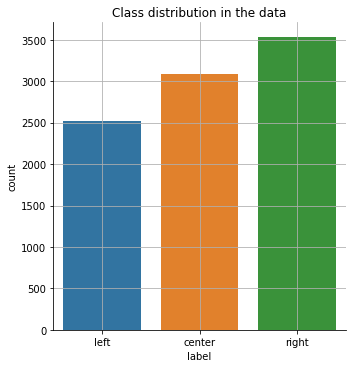

In [9]:
sns.factorplot('label',data = data,kind='count')
plt.grid()
plt.title("Class distribution in the data");

Создание новой фичи

In [10]:
train['all_text'] = train['title']+train['content']
val['all_text'] = val['title']+val['content']
test['all_text'] = test['title']+test['content']

#Лемматизация

In [13]:
m = MorphAnalyzer()
regex = re.compile("[A-Za-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('english') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [14]:
from multiprocessing import Pool as PoolSklearn
#train
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, train['all_text']), total=len(train)))
    
train['lemmas'] = lemmas
train.sample(5)

#val
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, val['all_text']), total=len(val)))  
val['lemmas'] = lemmas
val.sample(5)

#test 
with PoolSklearn(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, test['all_text']), total=len(test)))
    
test['lemmas'] = lemmas
test.sample(5)

100%|██████████| 921/921 [00:06<00:00, 136.32it/s]


,title,content,label,all_text,label_enc,lemmas
317,Facebook and Twitter suspend Russian propagand...,Source: ZDNet\n\nFacebook and Twitter said on ...,center,Facebook and Twitter suspend Russian propagand...,0,facebook twitter suspend russian propaganda ac...
893,Ancient City Discovered In Egypt,NaN,center,NaN,0,
192,Abolishing the filibuster is unlikely to happen,Op-Ed\n\nCould abolishing the filibuster to en...,right,Abolishing the filibuster is unlikely to happe...,2,abolishing filibuster unlikely happenop could ...
870,Promises Don't Feed Hungry People: World Food ...,"Our world produces enough food for every man, ...",left,Promises Don't Feed Hungry People: World Food ...,1,promises feed hungry people world food world p...
608,Intro Page: Ad Apex,Custom Content Ratings Services\n\nOur team of...,center,Intro Page: Ad ApexCustom Content Ratings Serv...,0,intro page apexcustom content ratings services...


In [15]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train['label_enc'] = labelencoder.fit_transform(train['label'])
val['label_enc'] = labelencoder.transform(val['label'])
test['label_enc'] = labelencoder.transform(test['label'])
train

,title,content,label,all_text,label_enc,lemmas
0,Election Integrity,Some academics and pundits have been postulati...,left,Election IntegritySome academics and pundits h...,1,election integritysome academics pundits postu...
1,"It's Time to Junk ""Junk Insurance""","About four years ago, I was a 40 year old heal...",left,"It's Time to Junk ""Junk Insurance""About four y...",1,time junk junk insurance four years year healt...
2,Republicans Want to Steal This Election for Tr...,— from Salon\n\nDonald Trump is still trying t...,left,Republicans Want to Steal This Election for Tr...,1,republicans want steal election trump know sal...
3,Mitch McConnell’s True Colors May Finally Sink...,"If you’re listening to politicians, you hear t...",left,Mitch McConnell’s True Colors May Finally Sink...,1,mitch mcconnell true colors finally sink himif...
4,"Trump Gone, But the Right-Wing Leadership Inst...","We’re familiar with Fox, the TV propaganda arm...",left,"Trump Gone, But the Right-Wing Leadership Inst...",1,trump gone right wing leadership institute pro...
...,...,...,...,...,...,...
7327,10 Best Snack Subscription Boxes 2021 — Monthl...,Where do I begin? Snacks are amazing. How does...,left,10 Best Snack Subscription Boxes 2021 — Monthl...,1,best snack subscription boxes monthly food dri...
7328,Stylist Says Justin Timberlake Set Up Janet Ja...,Update:\n\nFYI: A source close to Justin Timbe...,left,Stylist Says Justin Timberlake Set Up Janet Ja...,1,stylist says justin timberlake janet jackson w...
7329,47 Luxury Gift Ideas — Expensive and Designer ...,"Sure, there are gifts under $5, under $20, and...",left,47 Luxury Gift Ideas — Expensive and Designer ...,1,luxury gift ideas expensive designer gifts sur...
7330,50 Famous Actors You Probably Forgot Were on G...,Jennifer Westfeldt\n\nAfter accidentally runni...,left,50 Famous Actors You Probably Forgot Were on G...,1,famous actors probably forgot grey anatomyjenn...


In [16]:
data = train.append(val)
data = data.append(test)
data.shape

(9139, 6)

# Tf-Idf для кластеризации

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(ngram_range=(1, 2))
data_vec = vec.fit_transform(data['lemmas'])


In [ ]:
data_vec.shape

(8765, 2385696)

# Tf-Idf

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
vec = TfidfVectorizer(ngram_range=(1, 3))
train_vec = vec.fit_transform(train['lemmas'])
test_vec = vec.transform(test['lemmas'])
val_vec = vec.transform(val['lemmas'])

In [19]:
y_train = train['label_enc']
y_test = test['label_enc']
y_val = val['label_enc']

# Кластеризация

Метод к-средних - KMeans

In [ ]:
num_clusters = 5
from sklearn.cluster import KMeans

km = KMeans(n_clusters=num_clusters)
idx = km.fit(data_vec)

In [ ]:
clusterkm  = km.labels_.tolist()

In [ ]:
clusterkm = km.labels_.tolist()
out = { 'title': data['title'].tolist(), 'cluster': clusterkm, 'text': data['content'].tolist() }
frame1 = pd.DataFrame(out, index = np.arange(len(clusterkm)), columns = ['title', 'cluster','text'])

In [ ]:
frame1['cluster'].value_counts()

3    4739
2    2030
4     962
1     596
0     438
Name: cluster, dtype: int64

Применим PCA для возможности отобразить результату кластеризации

In [ ]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2)

In [ ]:
pca.fit(data_vec)

TruncatedSVD()

In [ ]:
data_2  = pca.transform(data_vec)

In [ ]:
#создаем data frame, который содержит координаты (из PCA) + номера кластеров и сами запросы
df = pd.DataFrame(dict(x=data_2[:,0], y=data_2[:,1], label=clusterkm, title=data['title'].tolist())) 
#группируем по кластерам
groups = df.groupby('label',sort=False)

In [ ]:
cluster_colors = {0: 'red',1: '#FFA812', 2: 'green',  3: 'magenta', 4: 'blue'}
cluster_names = {0: 'Criminalistics', 1: 'COVID-19', 2: 'Recommendations',  3: 'Culture', 4: 'Policy'}

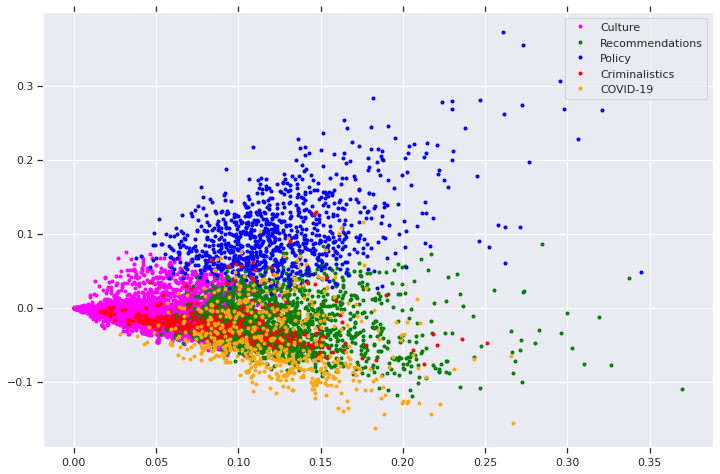

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(        axis= 'y',         
        which='both',     
        left='off',      
        top='off',       
        labelleft='off')
    
ax.legend(numpoints=1)
plt.show() 

In [ ]:
def alert(row):
  if row['cluster'] == 0:
    return 'Criminalistics'
  elif row['cluster'] == 1:
    return 'COVID-19'
  elif row['cluster'] == 2:
    return 'Recommendations'
  elif row['cluster'] == 3:
    return 'Culture'
  else:
    return 'Policy'


frame1['news_cluster'] = frame1.apply(alert, axis=1)

Взглянем на распределение тем в новостях

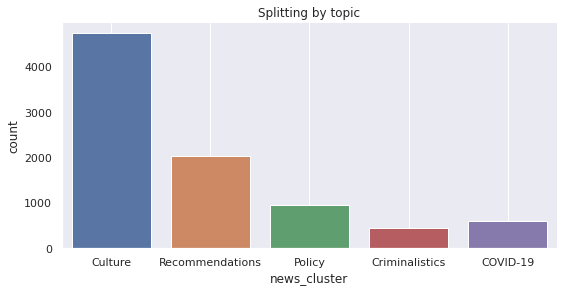

In [ ]:
sns.factorplot('news_cluster',data = frame1,kind='count', size=4, aspect=2)
plt.grid(which='both')
plt.title("Splitting by topic");

# Классификация

## Baseline

In [20]:
from sklearn.svm import LinearSVC
clf_1 = LinearSVC()
clf_1.fit(train_vec, y_train)

LinearSVC()

In [21]:
scores_F1 ={}
scores_MAE ={}
scores_Accuracy = {}

In [22]:
import tensorflow as tf

y_pred = clf_1.predict(test_vec)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)
y_proba_cb = clf_1._predict_proba_lr(test_vec)

In [23]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Baseline'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Baseline'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Baseline'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6389236256710515
Accuracy: 0.6416938110749185
MAE: 0.39721592570879455


## LightGBM

In [24]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()

In [25]:
clf.fit(train_vec, y_train)

LGBMClassifier()

In [26]:
import tensorflow as tf

y_pred = clf.predict(test_vec)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)
y_proba_cb = clf.predict_proba(test_vec)

In [27]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['LightGBM'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['LightGBM'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['LightGBM'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.5990831610412967
Accuracy: 0.6026058631921825
MAE: 0.32581870049241646


## BERT

In [28]:
train.loc[train["lemmas"] == "", "lemmas"] = np.nan
test.loc[test["lemmas"] == "", "lemmas"] = np.nan
val.loc[val["lemmas"] == "", "lemmas"] = np.nan

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7332 entries, 0 to 7331
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      7332 non-null   object
 1   content    7043 non-null   object
 2   label      7332 non-null   object
 3   all_text   7043 non-null   object
 4   label_enc  7332 non-null   int64 
 5   lemmas     7029 non-null   object
dtypes: int64(1), object(5)
memory usage: 343.8+ KB


In [37]:
train = train.dropna()
val = val.dropna()
test = test.dropna()

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7029 entries, 0 to 7331
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      7029 non-null   object
 1   content    7029 non-null   object
 2   label      7029 non-null   object
 3   all_text   7029 non-null   object
 4   label_enc  7029 non-null   int64 
 5   lemmas     7029 non-null   object
dtypes: int64(1), object(5)
memory usage: 384.4+ KB


In [39]:
y_train = train['label_enc']
y_test = test['label_enc']
y_val = val['label_enc']

In [40]:
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers.legacy import Adam

In [42]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(
        3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    
    loss = tf.keras.losses.SquaredHinge(name='squared_hinge')
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(
        learning_rate=4e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model

In [43]:
tfhub_handle_encoder = \
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = \
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [44]:
classifier_model = build_classifier_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [45]:
y_train = tf.keras.utils.to_categorical(
    train['label_enc'], num_classes=3)
y_val = tf.keras.utils.to_categorical(
    val['label_enc'], num_classes=3)

history = classifier_model.fit(
    x = train['lemmas'].values,
    y = y_train,
    validation_data=(val['lemmas'].values, y_val),
    epochs=10)

Epoch 1/10
220/220 [==============================] - 87s 284ms/step - loss: 1.2582 - accuracy: 0.4942 - val_loss: 1.2825 - val_accuracy: 0.4691
Epoch 2/10
220/220 [==============================] - 59s 268ms/step - loss: 1.1746 - accuracy: 0.5780 - val_loss: 1.2446 - val_accuracy: 0.5046
Epoch 3/10
220/220 [==============================] - 58s 266ms/step - loss: 1.1275 - accuracy: 0.6281 - val_loss: 1.2463 - val_accuracy: 0.5149
Epoch 4/10
220/220 [==============================] - 58s 266ms/step - loss: 1.0918 - accuracy: 0.6642 - val_loss: 1.2363 - val_accuracy: 0.5263
Epoch 5/10
220/220 [==============================] - 65s 294ms/step - loss: 1.0671 - accuracy: 0.6883 - val_loss: 1.2335 - val_accuracy: 0.5320
Epoch 6/10
220/220 [==============================] - 58s 266ms/step - loss: 1.0484 - accuracy: 0.6995 - val_loss: 1.2362 - val_accuracy: 0.5240
Epoch 7/10
220/220 [==============================] - 59s 268ms/step - loss: 1.0312 - accuracy: 0.7186 - val_loss: 1.2375 - val_ac

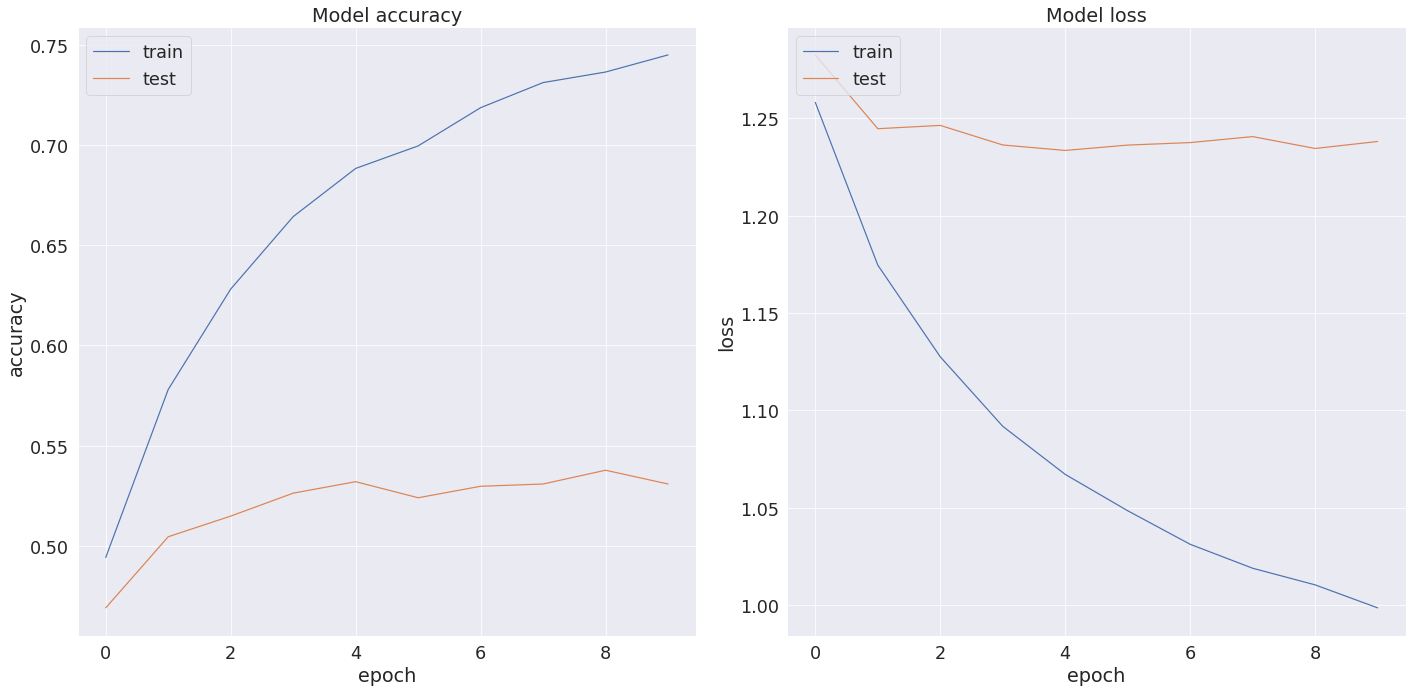

In [46]:
sns.set()
sns.set_context("paper", font_scale=2) 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
sns.lineplot(ax=ax1, data=history.history['accuracy'])
sns.lineplot(ax=ax1, data=history.history['val_accuracy'])
ax1.set(
    title=f"Model accuracy",
    xlabel="epoch",
    ylabel="accuracy"
)
ax1.legend(['train', 'test'], loc='upper left')
ax2 = fig.add_subplot(122)
sns.lineplot(ax=ax2, data=history.history['loss'])
sns.lineplot(ax=ax2, data=history.history['val_loss'])
ax2.set(
    title=f"Model loss",
    xlabel="epoch",
    ylabel="loss"
)
ax2.legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show(fig) 

In [47]:
y_test = tf.keras.utils.to_categorical(
    test['label_enc'].astype('category'), num_classes=3)

In [48]:
y_proba_cb  = classifier_model.predict(test['lemmas'].values)
y_pred = np.argmax(y_proba_cb, axis=1)
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

27/27 [==============================] - 4s 118ms/step


In [49]:
from sklearn.metrics import f1_score ,mean_absolute_error, accuracy_score

print('F1:',f1_score(y_pred, np.argmax(y_test,axis = 1), average='macro'))
scores_F1['BERT'] = f1_score(y_pred, np.argmax(y_test,axis = 1), average='macro')
print('Accuracy:',accuracy_score(y_pred, np.argmax(y_test,axis = 1)))
scores_Accuracy['BERT'] = accuracy_score(y_pred, np.argmax(y_test,axis = 1))
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['BERT'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6222936665971465
Accuracy: 0.6233766233766234
MAE: 0.27089128


# Catboost


In [50]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.8 MB/s eta 0:00:00


In [51]:
train

,title,content,label,all_text,label_enc,lemmas
0,Election Integrity,Some academics and pundits have been postulati...,left,Election IntegritySome academics and pundits h...,1,election integritysome academics pundits postu...
1,"It's Time to Junk ""Junk Insurance""","About four years ago, I was a 40 year old heal...",left,"It's Time to Junk ""Junk Insurance""About four y...",1,time junk junk insurance four years year healt...
2,Republicans Want to Steal This Election for Tr...,— from Salon\n\nDonald Trump is still trying t...,left,Republicans Want to Steal This Election for Tr...,1,republicans want steal election trump know sal...
3,Mitch McConnell’s True Colors May Finally Sink...,"If you’re listening to politicians, you hear t...",left,Mitch McConnell’s True Colors May Finally Sink...,1,mitch mcconnell true colors finally sink himif...
4,"Trump Gone, But the Right-Wing Leadership Inst...","We’re familiar with Fox, the TV propaganda arm...",left,"Trump Gone, But the Right-Wing Leadership Inst...",1,trump gone right wing leadership institute pro...
...,...,...,...,...,...,...
7327,10 Best Snack Subscription Boxes 2021 — Monthl...,Where do I begin? Snacks are amazing. How does...,left,10 Best Snack Subscription Boxes 2021 — Monthl...,1,best snack subscription boxes monthly food dri...
7328,Stylist Says Justin Timberlake Set Up Janet Ja...,Update:\n\nFYI: A source close to Justin Timbe...,left,Stylist Says Justin Timberlake Set Up Janet Ja...,1,stylist says justin timberlake janet jackson w...
7329,47 Luxury Gift Ideas — Expensive and Designer ...,"Sure, there are gifts under $5, under $20, and...",left,47 Luxury Gift Ideas — Expensive and Designer ...,1,luxury gift ideas expensive designer gifts sur...
7330,50 Famous Actors You Probably Forgot Were on G...,Jennifer Westfeldt\n\nAfter accidentally runni...,left,50 Famous Actors You Probably Forgot Were on G...,1,famous actors probably forgot grey anatomyjenn...


Добавим переменную длинна всего текста


In [52]:
train['sym_len'] = train.lemmas.apply(len)
train['word_len'] = train.lemmas.apply(lambda x: len(x.split()))

val['sym_len'] = val.lemmas.apply(len)
val['word_len'] = val.lemmas.apply(lambda x: len(x.split()))

test['sym_len'] = test.lemmas.apply(len)
test['word_len'] = test.lemmas.apply(lambda x: len(x.split()))

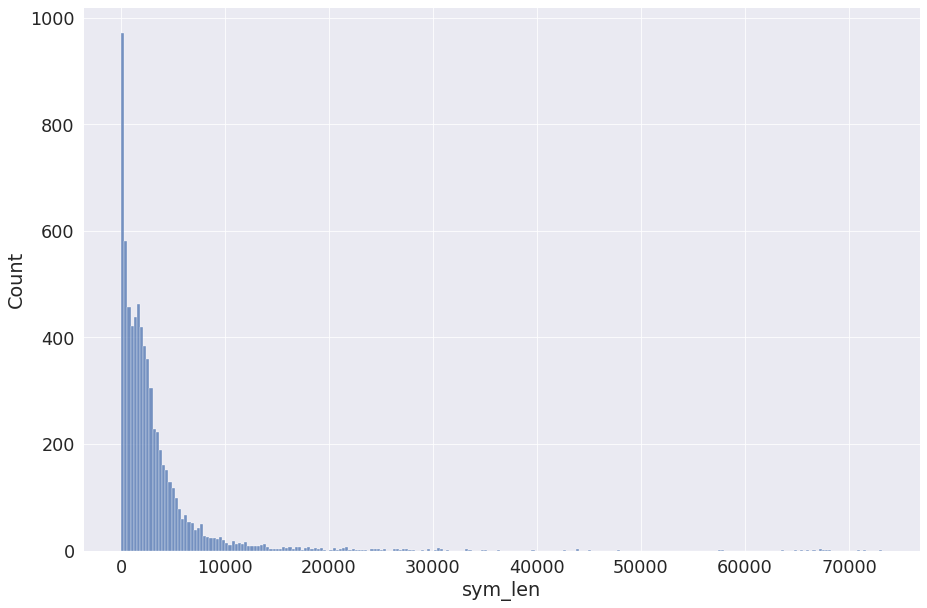

In [53]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train.sym_len)
plt.show()

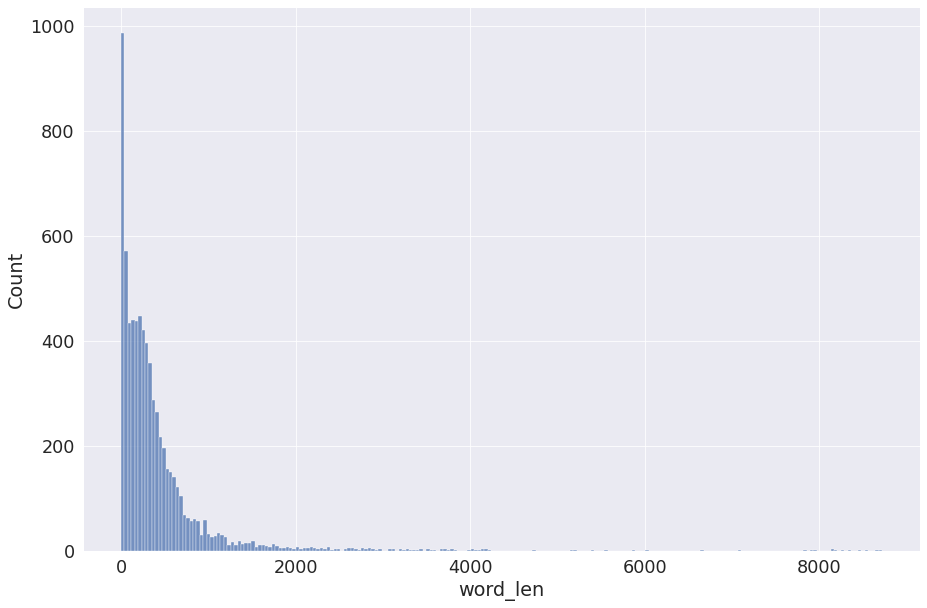

In [54]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train.word_len)
plt.show()

Вимдим, что распредление с длинным хвостом, поэтому логорифмируем эти фичи

In [55]:
train['sym_len'] = np.log(train['sym_len'])
train['word_len'] = np.log(train['word_len'])
test['sym_len'] = np.log(test['sym_len'])
test['word_len'] = np.log(test['word_len'])
val['sym_len'] = np.log(val['sym_len'])
val['word_len'] = np.log(val['word_len'])

<AxesSubplot:>

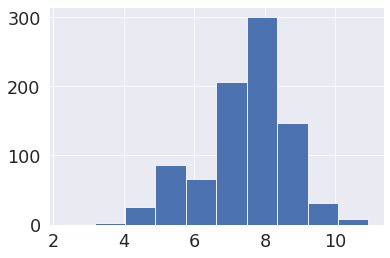

In [56]:
val['sym_len'].hist()

In [57]:
df_train = train[['title','all_text','lemmas','content','sym_len', 'word_len']]
y_train = train['label_enc']
df_val = val[['title','all_text','lemmas','content','sym_len', 'word_len']]
y_val = val['label_enc']
df_test = test[['title','all_text','lemmas','content','sym_len', 'word_len']]
y_test = test['label_enc']

In [60]:
from catboost import CatBoostClassifier
from catboost import Pool


def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        use_best_model= True,
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [61]:
train_pool = Pool(
    df_train, y_train, 
    text_features=['title','all_text','lemmas','content'],
)

validation_pool = Pool(
    df_val, y_val, 
    text_features=['title','all_text','lemmas','content'],
)

test_pool = Pool(
    df_test, y_test, 
    text_features=['title','all_text','lemmas','content'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool)

Train dataset shape: (7029, 6)

0:	learn: 1.0521431	test: 1.0730683	best: 1.0730683 (0)	total: 38.8ms	remaining: 38.8s
100:	learn: 0.7085378	test: 0.9716432	best: 0.9716432 (100)	total: 1.5s	remaining: 13.4s
200:	learn: 0.6466000	test: 0.9617769	best: 0.9617769 (200)	total: 2.68s	remaining: 10.7s
300:	learn: 0.6029864	test: 0.9591149	best: 0.9582796 (238)	total: 3.8s	remaining: 8.83s
400:	learn: 0.5690269	test: 0.9610632	best: 0.9581757 (308)	total: 7.04s	remaining: 10.5s
500:	learn: 0.5422061	test: 0.9571519	best: 0.9548162 (487)	total: 8.21s	remaining: 8.17s
600:	learn: 0.5211027	test: 0.9584656	best: 0.9548162 (487)	total: 9.31s	remaining: 6.18s
700:	learn: 0.5011263	test: 0.9578941	best: 0.9548162 (487)	total: 11.4s	remaining: 4.85s
800:	learn: 0.4815629	test: 0.9580708	best: 0.9548162 (487)	total: 14.8s	remaining: 3.68s
900:	learn: 0.4634897	test: 0.9606277	best: 0.9548162 (487)	total: 22.9s	remaining: 2.51s
999:	learn: 0.4484449	test: 0.9625962	best: 0.9548162 (487)	total: 25.6s	

In [62]:
!pip install numba

from numba import cuda 
device = cuda.get_current_device()
device.reset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


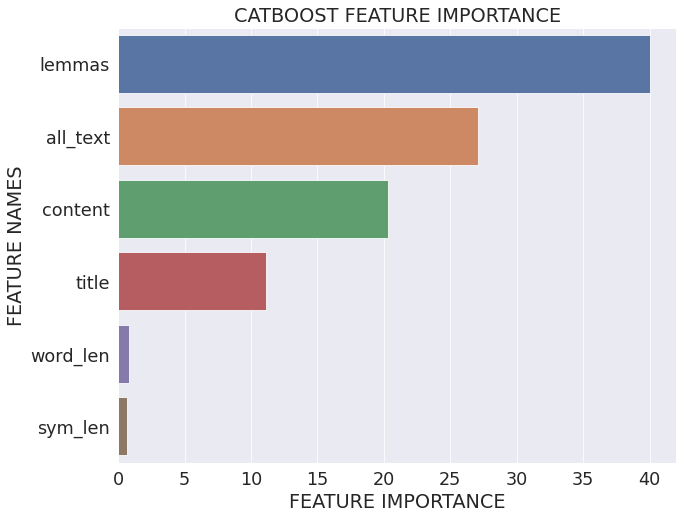

In [63]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
#plot the catboost result
plot_feature_importance(model.get_feature_importance(),df_train.columns,'CATBOOST ')

In [64]:
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)

In [65]:
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

In [66]:
print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['Catboost'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['Catboost'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['Catboost'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.6909185898432583
Accuracy: 0.6942148760330579
MAE: 0.29494498252307294


## xgboost

In [67]:
from xgboost import XGBClassifier

In [70]:
clf_3 = XGBClassifier(tree_method='gpu_hist')

In [72]:
y_train = train[['label_enc']]

In [76]:
train_vec = vec.fit_transform(train['lemmas'])

In [77]:
y_train.shape

(7029, 1)

In [78]:
train_vec.shape

(7029, 4589795)

In [79]:
clf_3.fit(train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [84]:
test_vec = vec.transform(test['lemmas'])

In [85]:
y_proba_cb = clf_3.predict_proba(test_vec)
y_pred = np.argmax(y_proba_cb, axis=1)

In [86]:
test_y = tf.keras.utils.to_categorical(
    test['label_enc'], num_classes=3)

In [87]:
print('F1:',f1_score(y_pred, y_test, average='macro'))
scores_F1['xgboost'] = f1_score(y_pred, y_test, average='macro')
print('Accuracy:',accuracy_score(y_pred, y_test))
scores_Accuracy['xgboost'] = accuracy_score(y_pred, y_test)
print('MAE:',mean_absolute_error(y_proba_cb, test_y))
scores_MAE['xgboost'] = mean_absolute_error(y_proba_cb,test_y)

F1: 0.17413399454987358
Accuracy: 0.2975206611570248
MAE: 0.46820655


#Результаты

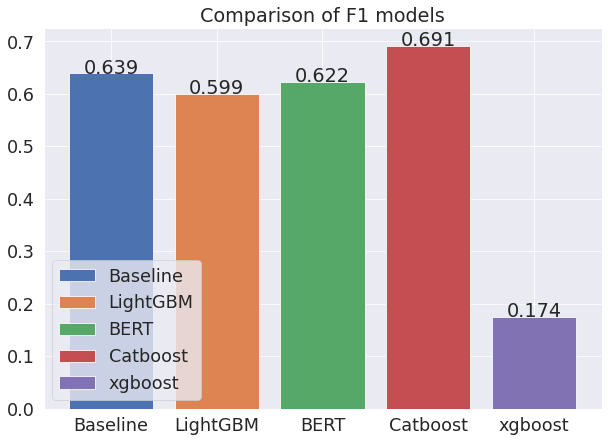

In [88]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in scores_F1.keys():
  ax.bar(i,scores_F1[i], label=i)
  plt.text(i,scores_F1[i],round(scores_F1[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of F1 models")
plt.show()

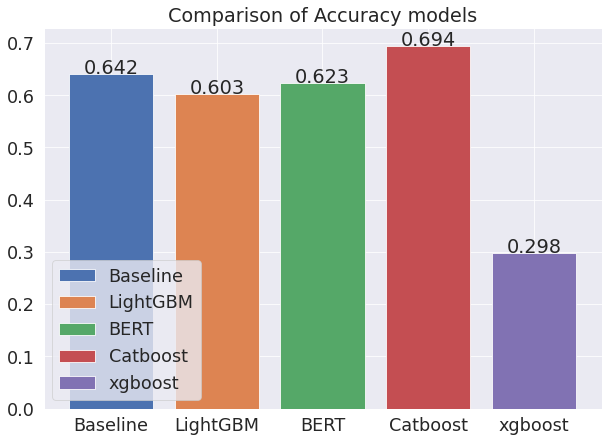

In [89]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in scores_Accuracy.keys():
  ax.bar(i,scores_Accuracy[i], label=i)
  plt.text(i,scores_Accuracy[i],round(scores_Accuracy[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of Accuracy models")
plt.show()

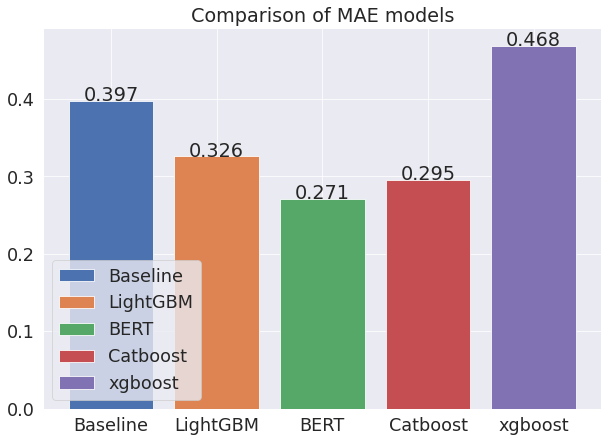

In [90]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in scores_MAE.keys():
  ax.bar(i,scores_MAE[i], label=i)
  plt.text(i,scores_MAE[i],round(scores_MAE[i],3), ha = 'center')
ax.legend(loc='lower left')
plt.title("Comparison of MAE models")
plt.show()